`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Auto_for_lab` (источник: <https://github.com/aksyuk/MTML/blob/main/Labs/data/Auto_for_lab.csv>)
mpg - сколько миль проходит автомобиль на галлоне топлива;

cylinders – количество цилиндров;

displacement – объём двигателя (в кубических дюймах);

horsepower – мощность (в лошадиных силах);

weight – масса (в фунтах);

acceleration – время разгона с 0 до 60 миль в час (в секундах);

year – год выпуска модели (XX век);

origin – страна происхождения: 1 - США, 2 - Европа, 3 - Япония;

name – название модели;

cyl_over_4 – фиктивная переменная: 1 если число цилиндров больше 4.

mpg - зависимая переменная

displacement, weight, cyl_over_4 - объясняющие переменные

In [198]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Указания к выполнению


## Загружаем пакеты

In [199]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [200]:
# константы
#  ядро для генератора случайных чисел
my_seed = 8
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные
  
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [201]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/Auto_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (392, 10)


In [202]:
# первые 5 строк фрейма
DF_raw.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,cyl_over_4
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1


In [203]:
# типы столбцов фрейма
DF_raw.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
cyl_over_4        int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [204]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
cyl_over_4      0
dtype: int64

Пропусков не обнаружено.  

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [205]:
DF_raw = DF_raw[['displacement', 'weight', 'mpg', 'cyl_over_4']]
DF_raw.head()

,displacement,weight,mpg,cyl_over_4
0,307.0,3504,18.0,1
1,350.0,3693,15.0,1
2,318.0,3436,18.0,1
3,304.0,3433,16.0,1
4,302.0,3449,17.0,1


In [206]:
# данные для построения моделей
DF = DF_raw.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_raw.drop(DF.index)

In [207]:
DF.head(10)

,displacement,weight,mpg,cyl_over_4
297,141.0,3190,27.2,0
175,115.0,2694,23.0,0
8,455.0,4425,14.0,1
163,262.0,3221,20.0,1
254,225.0,3430,20.5,1
238,97.0,2190,30.5,0
37,350.0,4209,14.0,1
208,156.0,2930,19.0,1
0,307.0,3504,18.0,1
109,108.0,2379,22.0,0


In [208]:
DF_predict.head(10)

,displacement,weight,mpg,cyl_over_4
2,318.0,3436,18.0,1
7,440.0,4312,14.0,1
9,390.0,3850,15.0,1
16,199.0,2774,18.0,1
18,97.0,2130,27.0,0
19,97.0,1835,26.0,0
20,110.0,2672,25.0,0
21,107.0,2430,24.0,0
28,304.0,4732,9.0,1
31,113.0,2228,25.0,0


## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `mpg`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `cyl_over_4` принимает нулевые значения. Остальные показатели положительны.  

In [209]:
# описательные статистики для непрерывных переменных
DF[['mpg', 'displacement', 'weight']].describe()

,mpg,displacement,weight
count,314.000000,314.000000,314.000000
mean,23.392675,193.431529,2974.668790
std,7.564680,103.757193,839.268622
min,10.000000,68.000000,1613.000000
25%,17.125000,105.000000,2245.250000
50%,22.400000,148.500000,2831.500000
75%,29.000000,261.500000,3571.250000
max,44.300000,455.000000,5140.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

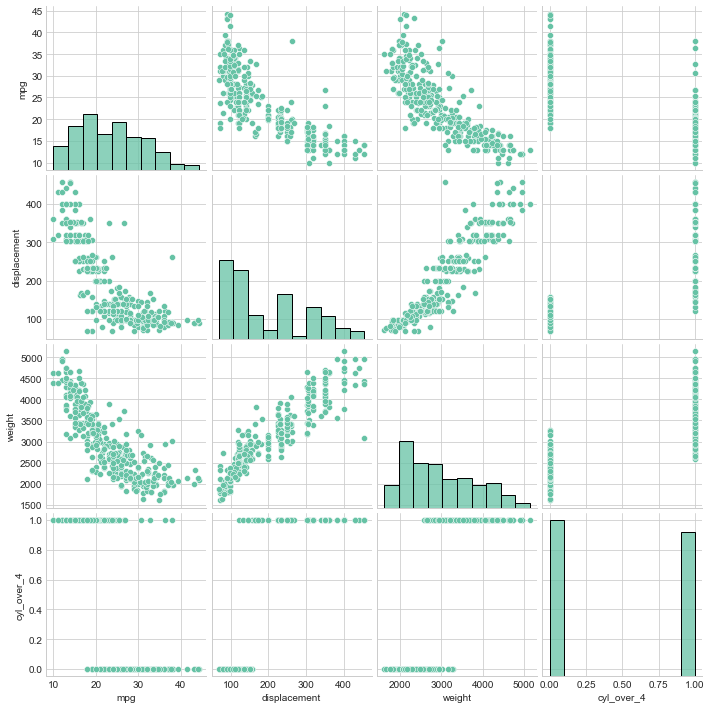

In [210]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['mpg', 'displacement', 'weight', 'cyl_over_4']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `mpg` не является нормальным;  
* ни одна из объясняющих не распределена нормально;
* объясняющая `cyl_over_4` дискретна, другие же переменные непрерывны;  
* наблюдается линейная связь у mpg и weight (однако некоторые точки значительно отклоняются), возможно связь умеренная.

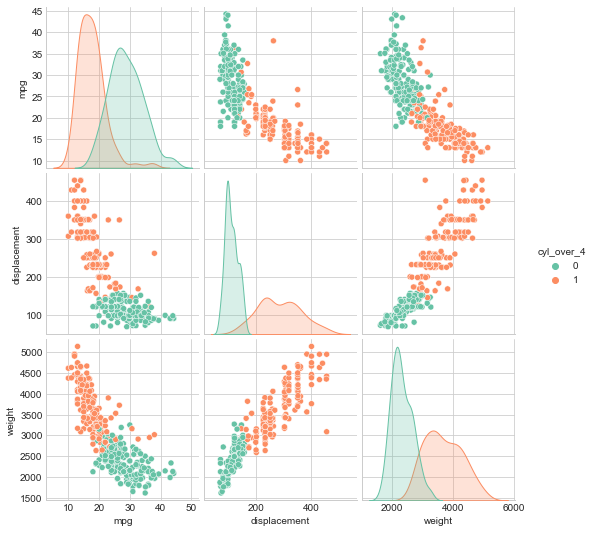

In [211]:
# матричный график разброса с цветом по полу
sns.pairplot(DF[['mpg', 'displacement', 'weight', 'cyl_over_4']],
            hue='cyl_over_4')

plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма.

In [212]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,mpg,displacement,weight
mpg,1.00,-0.80,-0.83
displacement,-0.80,1.00,0.93
weight,-0.83,0.93,1.00


Посчитаем корреляционные матрицы если число цилиндров больше 4, т.е. фиктивная переменная = 1.

In [213]:
corr_mat = DF.loc[DF['cyl_over_4'] == 1][['mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,mpg,displacement,weight
mpg,1.00,-0.67,-0.68
displacement,-0.67,1.00,0.80
weight,-0.68,0.80,1.00


Посчитаем корреляционные матрицы если число цилиндров не больше 4, т.е. фиктивная переменная = 0.

In [214]:
corr_mat = DF.loc[DF['cyl_over_4'] == 0][['mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,mpg,displacement,weight
mpg,1.00,-0.36,-0.51
displacement,-0.36,1.00,0.78
weight,-0.51,0.78,1.00


*Вывод:*
Количество миль, которое проходит автомобиль, достаточно сильно зависит от объема двигателя в том случае, если количество цилиндров больше 4, в обратном же случае корреляция меньше почти вдвое.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [215]:
# логарифмируем зависимую переменную
DF['log_mpg'] = np.log(DF['mpg'])

# DF_predict['log_medv'] = np.log(DF_predict['medv'])
# описательные статистики для непрерывных показателей
#DF[['charges', 'log_charges', 'age', 'bmi', 'children']].describe()

Проведём формальные тесты на нормальность.  

In [216]:
# тестируем на нормальность
for col in ['mpg', 'log_mpg']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

mpg Statistics=0.97, p=0.0000
Распределение не нормально (H0 отклоняется)

log_mpg Statistics=0.98, p=0.0001
Распределение не нормально (H0 отклоняется)



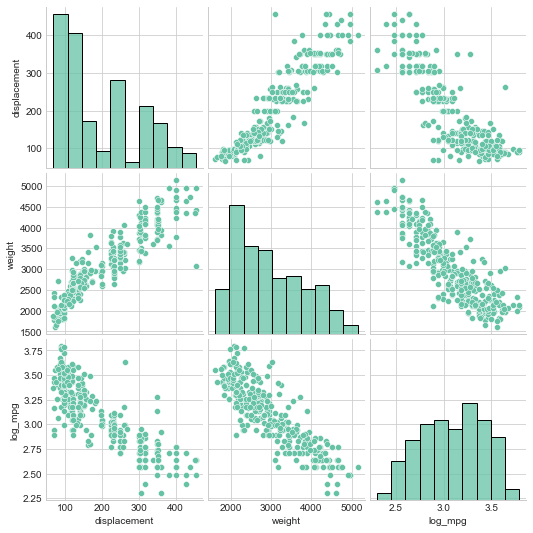

In [217]:
sns.pairplot(DF[['displacement', 'weight', 'log_mpg']])
plt.show()

Логарифмирование меняет взаимосвязи между переменными.   

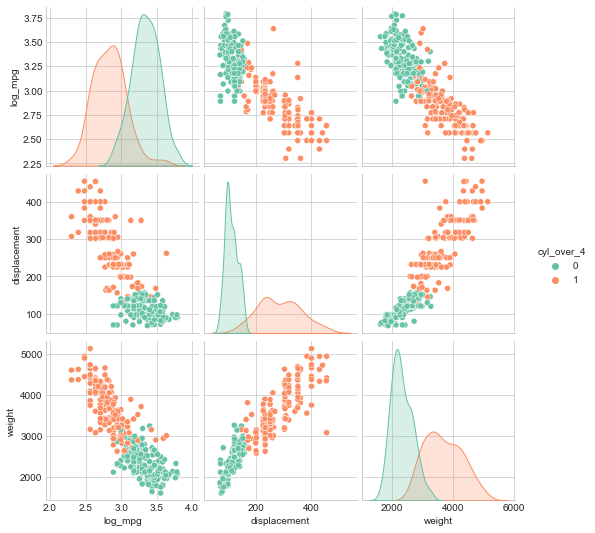

In [218]:
# матричный график разброса с цветом по cyl_over_4
sns.pairplot(DF[['log_mpg', 'displacement', 'weight', 'cyl_over_4']], hue='cyl_over_4')
plt.show()

Количество пройденных миль очевидно сильно зависит от фиктивной переменной.  После логарифмирования log_mpg по-прежнему нераспределена нормально, однако функция плотности на графике выглядит более нормальной, чем была у mpg.

In [219]:
corr_mat = DF[['log_mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_mpg,displacement,weight
log_mpg,1.00,-0.85,-0.87
displacement,-0.85,1.00,0.93
weight,-0.87,0.93,1.00


In [220]:
corr_mat = DF.loc[DF['cyl_over_4'] == 0][['log_mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_mpg,displacement,weight
log_mpg,1.00,-0.35,-0.52
displacement,-0.35,1.00,0.78
weight,-0.52,0.78,1.00


In [221]:
corr_mat = DF.loc[DF['cyl_over_4'] == 1][['log_mpg', 'displacement', 'weight']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_mpg,displacement,weight
log_mpg,1.00,-0.71,-0.74
displacement,-0.71,1.00,0.80
weight,-0.74,0.80,1.00


Можно убедиться, что линейные связи с учётом cyl_over_4 значительно ослабевают. Значит на обучающей выборке ошибка модели будет больше.

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl_over_4 + \hat{\beta_2} \cdot displacement + \hat{\beta_3} \cdot weight$

2. `fit_lm_2`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl_over_4 + \hat{\beta_2} \cdot displacement \cdot cyl_over_4 + \hat{\beta_3} \cdot weight$

3. `fit_lm_3`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl_over_4 + \hat{\beta_2} \cdot weight \cdot cyl_over_4 + \hat{\beta_3} \cdot displacement$

4. `fit_lm_4`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl_over_4 + \hat{\beta_2} \cdot weight \cdot cyl_over_4 + \hat{\beta_3} \cdot displacement \cdot cyl_over_4$



5. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_mpg}$

6. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_mpg}$

7. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_mpg}$

8. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_mpg}$


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [222]:
# данные для моделей 1, 5
df1 = DF[['mpg', 'cyl_over_4', 'displacement', 'weight']]

# данные для моделей 2, 6
df2 = DF[['mpg', 'cyl_over_4', 'displacement', 'weight']]
df2.loc[:, 'displacement_cyl_over_4'] = df2.loc[:, 'displacement'] * df2.loc[:, 'cyl_over_4']
df2 = df2.drop(['displacement'], axis=1)

# данные для моделей 3, 7
df3 = DF[['mpg', 'cyl_over_4', 'displacement', 'weight']]
df3.loc[:, 'weight_cyl_over_4'] = df3.loc[:, 'weight'] * df3.loc[:, 'cyl_over_4']
df3 = df3.drop(['weight'], axis=1)

# данные для моделей 4, 8
df4 = DF[['mpg', 'cyl_over_4', 'displacement', 'weight']]
df4.loc[:, 'displacement_cyl_over_4'] = df4.loc[:, 'displacement'] * df4.loc[:, 'cyl_over_4']
df4.loc[:, 'weight_cyl_over_4'] = df4.loc[:, 'weight'] * df4.loc[:, 'cyl_over_4']
df4 = df4.drop(['displacement', 'weight'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_mpg'], axis=1)

In [223]:
# проверка результатов
df0.head(5)

,displacement,weight,mpg,cyl_over_4
297,141.0,3190,27.2,0
175,115.0,2694,23.0,0
8,455.0,4425,14.0,1
163,262.0,3221,20.0,1
254,225.0,3430,20.5,1


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `charges` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [224]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['mpg'], axis=1)
y = df0.mpg.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [41.546] 
 объясняющие  ['displacement', 'weight', 'cyl_over_4'] 
 коэффициенты  [[-0.009 -0.005 -2.76 ]]


In [225]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([4.15056559])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [226]:
# модель со всеми объясняющими, y_log
X = df0.drop(['mpg'], axis=1)
y = np.log(df0.mpg).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.937] 
 объясняющие  ['displacement', 'weight', 'cyl_over_4'] 
 коэффициенты  [[-0.001 -0.    -0.073]]


In [227]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[-0.1, -0. , -7.1]])

In [228]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([4.0814987])

In [229]:
print('MSE_train модели для mpg меньше MSE_train',
     'модели для log(mpg) в ', np.around(MSE_log / MSE, 3), 'раз')

MSE_train модели для mpg меньше MSE_train модели для log(mpg) в  [0.967] раз


Это объясняется уменьшением корреляции для объясняющих переменных и прологарифмированной зависимой.

### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [230]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['mpg'], axis=1)
    y = df.mpg
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 10.34 секунд


In [231]:
df0.shape

(314, 4)

In [232]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['mpg'], axis=1)
    y = np.log(df.mpg)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 10.70 секунд


Сравним ошибки для моделей на исходных значениях `mpg` с ошибками моделей на логарифме.  

In [233]:
scores

[-17.674224172529218,
 -17.674224172529225,
 -17.74911899508016,
 -19.939155556844565,
 -21.025057986857817]

In [234]:
[np.around(-x, 5) for x in scores]

[17.67422, 17.67422, 17.74912, 19.93916, 21.02506]

In [235]:
[np.around(-x, 5) for x in scores_log]

[0.02591, 0.02591, 0.02586, 0.02918, 0.03075]

Определим самые точные модели отдельно на `mpg` и на `log_mpg`.  

In [236]:
# самая точная на mpg
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 17.674


In [237]:
# самая точная на log(mpg)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_2_log :
MSE_loocv = 0.026


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [238]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = df.mpg
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.42 секунд


In [239]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = np.log(df.mpg)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.33 секунд


In [240]:
scores

[-17.62153542191071,
 -17.720078023453187,
 -17.597639236731805,
 -19.958923050105014,
 -21.236115696413247]

In [241]:
[np.around(-x, 3) for x in scores]

[17.622, 17.72, 17.598, 19.959, 21.236]

In [272]:
# самая точная на mpg
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_2 :
MSE_kf10 = 17.598


In [273]:
[np.around(-x, 5) for x in scores]

[17.62154, 17.72008, 17.59764, 19.95892, 21.23612]

In [274]:
# самая точная на log(mpg)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_2_log :
MSE_kf10 = 0.026


Самой точной среди моделей для `mpg` оказалась `fit_lm_2`, а среди моделей для `mpg_log` – `fit_lm_2_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [276]:
# прогноз по fit_lm_2
#  модель на всех обучающих наблюдениях
X = df2.drop(['mpg'], axis=1)
y = df2.mpg.values.reshape(-1, 1)
fit_lm_2 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['mpg']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['cyl_over_4', 'displacement', 'weight']]
X.loc[:, 'displacement_cyl_over_4'] = X.loc[:, 'displacement'] * X.loc[:, 'cyl_over_4']
X = X.drop(['displacement'], axis=1)

#  прогнозы
y_pred = fit_lm_2.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_2 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_2 на отложенных наблюдениях = 19.79


In [277]:
# прогноз по fit_lm_log_2
#  модель на всех обучающих наблюдениях
X = df2.drop(['mpg'], axis=1)
y = np.log(df2.mpg).values.reshape(-1, 1)
fit_lm_2_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['mpg']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['cyl_over_4', 'displacement', 'weight']]
X.loc[:, 'displacement_cyl_over_4'] = X.loc[:, 'displacement'] * X.loc[:, 'cyl_over_4']
X = X.drop(['displacement'], axis=1)

#  прогнозы
y_pred = fit_lm_2_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_2_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_2_log на отложенных наблюдениях = 19.37


In [278]:
y_pred[:10]

array([[2.87154297],
       [2.58142952],
       [2.72454288],
       [3.10926983],
       [3.38629043],
       [3.4556534 ],
       [3.25885066],
       [3.31575181],
       [2.57647163],
       [3.36324782]])

In [279]:
np.around(np.sqrt(MSE_log) / np.mean(DF_predict[['mpg']]) * 100, 1)

mpg    18.6
dtype: float64

In [280]:
np.around(np.sqrt(MSE) / np.mean(DF_predict[['mpg']]) * 100, 1)

mpg    18.8
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_2_log`

## Результаты и их интерпретация

In [281]:
# прогноз по fit_lm_log_2
#  модель на всех обучающих наблюдениях
X = df2.drop(['mpg'], axis=1)
y = np.log(df2.mpg).values.reshape(-1, 1)
fit_lm_2_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['mpg']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['cyl_over_4', 'displacement', 'weight']]
X.loc[:, 'displacement_cyl_over_4'] = X.loc[:, 'displacement'] * X.loc[:, 'cyl_over_4']
X = X.drop(['displacement'], axis=1)

#  прогнозы
y_pred = fit_lm_2_log.predict(X)

Экспоненциируем параметры прологарифмированной модели

In [286]:
const_exp = np.exp(fit_lm_2_log.intercept_)
coef_exp = np.exp(fit_lm_2_log.coef_)

In [287]:
coef_exp_final = [(x-1)*100 for x in coef_exp]

In [288]:
print('Константа:', float(np.around(const_exp, 3)))

Константа: 48.77


In [291]:
print('Объясняющие:', list(df2.drop(['mpg'], axis=1).columns.values))

Объясняющие: ['cyl_over_4', 'weight', 'displacement_cyl_over_4']


In [292]:
print('Коэффициенты:', (np.around(coef_exp_final, 3)))

Коэффициенты: [[ 1.172 -0.024 -0.069]]


### Выводы:

Y = 48.77 + 1.172cyl_over_4 - 0.069displacement_cyl_over_4 - 0.024weight

При объясняющих переменных равных нулю Y равен 48.77.

Если дискретная переменная cyl_over_4 = 1, то Y увеличивается на 1.172, если же равно 0, тогда значение Y зависит только от непрерывных переменных. При увеличении displacement_cyl_over_4 на единицу, Y уменьшится на 0.069. При увеличении weight на единицу, Y уменьшится на 0.024. 

Ошибка на отложенных наблюдениях составляет 18.6% от среднего значения Y

### Проверка модели

In [293]:
DF_predict.head(10)

,displacement,weight,mpg,cyl_over_4
2,318.0,3436,18.0,1
7,440.0,4312,14.0,1
9,390.0,3850,15.0,1
16,199.0,2774,18.0,1
18,97.0,2130,27.0,0
19,97.0,1835,26.0,0
20,110.0,2672,25.0,0
21,107.0,2430,24.0,0
28,304.0,4732,9.0,1
31,113.0,2228,25.0,0


In [294]:
y_pred = fit_lm_2_log.predict(X[:10])
np.exp(y_pred)

array([[17.66425258],
       [13.21601727],
       [15.24944151],
       [22.40467931],
       [29.55610825],
       [31.6789811 ],
       [26.01961467],
       [27.54309351],
       [13.15065587],
       [28.88284489]])

Вывод: Проверка показала, что предсказанные моделью значения довольно схожи со значениями Y в отложенной выборке.

# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  